# Jupyter-Notebook for Machine Learning on Emission Data

### Predict Annual Emission with 4 arbitrary Train-Periods

#### Load Packages: 

In [1]:
import time
import numpy as np                 # package for numerics
import pandas as pd                # package for data frames  
import matplotlib.pyplot as plt    # package for plotting                     

# Machine Learning Packages (scikit-learn):
from sklearn.svm import SVR                           # Support Vector Machine
from sklearn.ensemble import RandomForestRegressor    # Random Forest
from sklearn.linear_model import Ridge                # Linear Regression (with Regularisation)
from sklearn.preprocessing import PolynomialFeatures  # for Linear Regression with Polynoms
from sklearn.neural_network import MLPRegressor       # Neural Net

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error as mae # Metric 
from sklearn.metrics import r2_score                   # Metric

from toolz import frequencies, valfilter

#### Display style for figures: 

In [2]:
# inline:   small, non-inteactive
# notebook: larger, interactive (zoom etc)
%matplotlib inline 
# %matplotlib notebook 

#### Load preprocessed data from text file (csv) into a "data frame":

In [5]:
df = pd.read_csv("data_method_4.dat", sep = " ")   # Import data

df.drop(["t"], axis = 1, inplace = True)

df.head()

,Temp,dt,vW,method,ef,wd,lg_ef,season4,h_sin,h_cos,t_sin,t_cos,dW_sin,dW_cos
0,13.175000,01NOV2016:11:00:00,2.134214,4,0.637836,W,-0.449675,2,2.588190e-01,-0.965926,0.0,1.0,-0.999999,0.001241
1,12.100000,01NOV2016:12:00:00,2.636442,4,1.025845,W,0.025517,2,1.224647e-16,-1.000000,0.0,1.0,-0.887852,0.460130
2,11.891667,01NOV2016:13:00:00,3.602638,4,1.536756,W,0.429674,2,-2.588190e-01,-0.965926,0.0,1.0,-0.723579,0.690241
3,11.833333,01NOV2016:14:00:00,2.994724,4,2.530530,W,0.928429,2,-5.000000e-01,-0.866025,0.0,1.0,-0.719382,0.694614
4,11.166667,01NOV2016:15:00:00,2.947266,4,1.543225,W,0.433874,2,-7.071068e-01,-0.707107,0.0,1.0,-0.778862,0.627195


#### We have to consider, that the data have a chronological order. To do so, we group them in 40 sequences of 1 weeks

In [6]:
# List with column "method" of data_frame df for indexing
method = df["method"]

# grouping data in 40 intervals of 1 week:
if (method[0] == 1): 

    nn = [144, 160, 167, 168, 166, 167, 168, 167, 168, 166, 168, 160, 167, 167, 168, 168, 165, 167, 164, 167, 
          165, 187, 133, 167, 167, 167, 167, 144, 166, 168, 166, 152,  56,  72,  67, 157, 166, 111, 114, 165]

elif (method[0] == 4):     
    
    nn = [145, 166, 168, 167, 167, 168, 168, 168, 168, 167, 168, 163, 168, 167, 168, 168, 162, 167, 168, 168,  
          166, 189, 146, 168, 168, 168, 168, 159, 168, 168, 168, 168, 167, 168, 168, 168, 168, 167, 167, 203]

else: 
    print("wrong method number")


groups = [0]*nn[0]+[1]*nn[1]+[2]*nn[2]+[3]*nn[3]+[4]*nn[4]+[5]*nn[5]+[6]*nn[6]+[7]*nn[7]+[8]*nn[8]+[9]*nn[9]+[10]*nn[10]+[11]*nn[11]+[12]*nn[12]+[13]*nn[13]+[14]*nn[14]+[15]*nn[15]+[16]*nn[16]+[17]*nn[17]+[18]*nn[18]+[19]*nn[19]+[20]*nn[20]+[21]*nn[21]+[22]*nn[22]+[23]*nn[23]+[24]*nn[24]+[25]*nn[25]+[26]*nn[26]+[27]*nn[27]+[28]*nn[28]+[29]*nn[29]+[30]*nn[30]+[31]*nn[31]+[32]*nn[32]+[33]*nn[33]+[34]*nn[34]+[35]*nn[35]+[36]*nn[36]+[37]*nn[37]+[38]*nn[38]+[39]*nn[39]

df["group"] = groups

groups   = df["group"].values
n_splits = max(df["group"].values) - min(df["group"].values) + 1

df.head()

,Temp,dt,vW,method,ef,wd,lg_ef,season4,h_sin,h_cos,t_sin,t_cos,dW_sin,dW_cos,group
0,13.175000,01NOV2016:11:00:00,2.134214,4,0.637836,W,-0.449675,2,2.588190e-01,-0.965926,0.0,1.0,-0.999999,0.001241,0
1,12.100000,01NOV2016:12:00:00,2.636442,4,1.025845,W,0.025517,2,1.224647e-16,-1.000000,0.0,1.0,-0.887852,0.460130,0
2,11.891667,01NOV2016:13:00:00,3.602638,4,1.536756,W,0.429674,2,-2.588190e-01,-0.965926,0.0,1.0,-0.723579,0.690241,0
3,11.833333,01NOV2016:14:00:00,2.994724,4,2.530530,W,0.928429,2,-5.000000e-01,-0.866025,0.0,1.0,-0.719382,0.694614,0
4,11.166667,01NOV2016:15:00:00,2.947266,4,1.543225,W,0.433874,2,-7.071068e-01,-0.707107,0.0,1.0,-0.778862,0.627195,0


In [7]:
corr_fac = [] 

m = len(df)

if (df["method"][0] == 1):

    for i in range(m):

        if( df["group"][i] == 32 ):
            corr_fac.append( 3.0 )
         
        elif( (df["group"][i] == 33) or (df["group"][i] == 34) ):
            corr_fac.append( 2.4 )
         
        elif( (df["group"][i] == 37) or (df["group"][i] == 38) ):
            corr_fac.append( 1.5 )
         
        else:
            corr_fac.append( 1.0 )
else:
    corr_fac = np.ones((m))

In [8]:
# summation over messurements [kg/a]

sum_exp = round(np.sum(df["ef"])/1000, 3)
sum_cor = round(np.sum(np.multiply(corr_fac, df["ef"]))/1000, 3)

print("NH3-Emission in kg per Livestock unit in 10 months:" )
print(" ")
print("Sum over measured values:                         ", sum_exp )
print("Sum over measured values with correction:         ", sum_cor )
print("Effective correction factor:                      ", round(sum_cor/sum_exp, 2))
print(" ")


NH3-Emission in kg per Livestock unit in 10 months:
 
Sum over measured values:                          9.439
Sum over measured values with correction:          9.439
Effective correction factor:                       1.0
 


### assign season to groups

In [9]:
# List with column "season" of data_frame df for indexing
season = df["season4"]   # try season 1, 2, 3 

# List with season of each week (len(gr_season) = 40, resp. 20)
gr_season = [] 
indx = 0

for i in range(0, len(nn)):
    
    gr_season.append(season[indx])

    indx = indx + nn[i]
    
    #print(gr_season[i])

#### For Machine Learning we need a matrix X of features and vector y of target-values (group is not a feature!).  

In [10]:
# Create feature matrix X (input-data) and target vector y (output-values): 
# X = df.drop(["dt", "method", "ef", "wd", "lg_ef", "season1", "season2", "season3", "group"], axis = 1).values 

X = df.drop(["dt", "method", "ef", "wd", "lg_ef", "season4", "group"], axis = 1).values 

y = df["lg_ef"].values  

print("X.shape:  ", X.shape)
print("y.shape:  ", y.shape)

X.shape:   (6699, 8)
y.shape:   (6699,)


In [11]:
train_size =  4
test_size  = 36  # together 40 groups! 
n_splits   = 10  # number of simulations

print("Number of simulations:  ", n_splits)

scaler  = StandardScaler()  # for normalization

cv = GroupShuffleSplit(n_splits = n_splits, train_size=train_size, test_size=test_size, random_state=0 )

Number of simulations:   10


## Linear Regression (multivariate) 

train_groups     season_of_train_groups    train_err   test_err   EF_pred
 
[0, 3, 9, 38]     [2, 2, 3, 1]     0.4377     0.5852     14.615
[10, 23, 31, 32]     [3, 2, 1, 1]     0.2899     0.4051     10.5145
[3, 4, 12, 36]     [2, 2, 3, 1]     0.2566     0.3908     8.0062
[2, 23, 34, 35]     [2, 2, 1, 1]     0.3123     0.4939     7.7683
[8, 13, 19, 31]     [2, 3, 2, 1]     0.2634     0.3743     8.1665
[1, 11, 15, 29]     [2, 3, 3, 1]     0.2603     0.3542     8.9067
[3, 23, 26, 38]     [2, 2, 2, 1]     0.3174     0.3953     8.8713
[3, 29, 30, 35]     [2, 1, 1, 1]     0.2251     0.3722     8.9935
[0, 16, 17, 22]     [2, 3, 3, 2]     0.5544     0.9488     5.4338
[0, 8, 15, 37]     [2, 2, 3, 1]     0.5062     0.366     8.3244
 
EF (y_train_pred + y_test_pred), mean, std:      8.925  2.261
EF (y_train      + y_test_pred), mean, std:      8.96  2.241
 
Experimental reference value, sum, error:       9.439  0.0


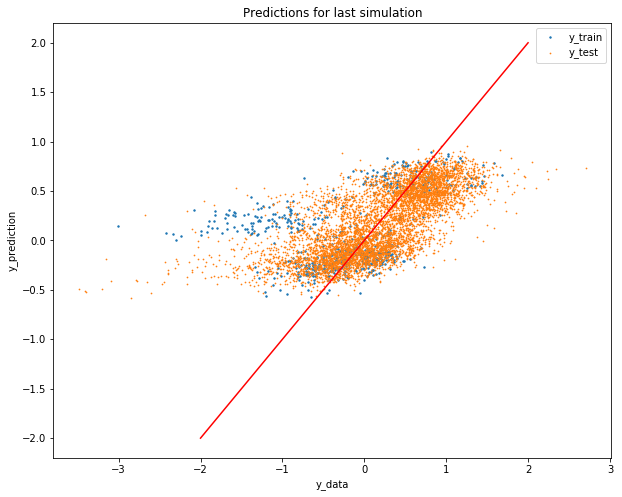

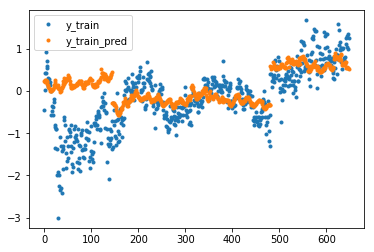

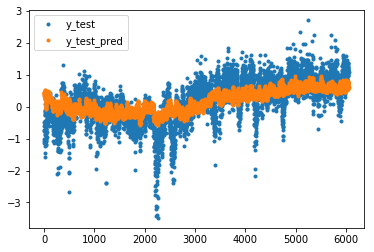

time (sec):   0.6813


In [13]:
# Ridge is a Linear Regression with Regularization (avoids overfitting)
model = Ridge(solver='lsqr', alpha=130.) 

t_start = time.time()

train_error = []
test_error  = []
cum_pred    = []  # cumulative emission from train and test prediction
cum_mixd    = []  # cumulative emission from train measurement and test prediction

print("train_groups     season_of_train_groups    train_err   test_err   EF_pred")
print(" ")

for train, test in cv.split( X, y, groups=groups ):
    
    X_train, y_train = X[train], y[train]
    X_test, y_test   = X[test], y[test]
    groups_test      = groups[test]
    groups_train     = groups[train]

    X_train = scaler.fit_transform(X_train) # calc mean and std for Train set and scale
    X_test  = scaler.transform(X_test)      # scale Test with mean and std from train set
    
    model.fit(X_train, y_train, groups_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_err    = mae(y_train, y_train_pred)
    test_err     = mae(y_test, y_test_pred)
    
    train_error.append( train_err )
    test_error.append( test_err )
    
    ef_pred_pred = np.sum(np.exp(y_train_pred))/1000 + np.sum(np.exp(y_test_pred))/1000
    ef_meas_pred = np.sum(np.exp(y_train))/1000      + np.sum(np.exp(y_test_pred))/1000
    
    cum_pred.append( ef_pred_pred )
    cum_mixd.append( ef_meas_pred )
    
    group_list = list(valfilter(lambda count: count > 1, frequencies(groups[train])).keys())

    season_list = [gr_season[group_list[0]],gr_season[group_list[1]],gr_season[group_list[2]],gr_season[group_list[3]]]
    
    print(group_list, season_list, round(train_err,4), round(test_err, 4), round(ef_meas_pred, 4), sep = "     " )

print(" ")
print("EF (y_train_pred + y_test_pred), mean, std:    ", round(np.mean(cum_pred),3), round(np.std(cum_pred),3), sep = "  " )
print("EF (y_train      + y_test_pred), mean, std:    ", round(np.mean(cum_mixd),3), round(np.std(cum_mixd),3), sep = "  " )

print(" ")
print("Experimental reference value, sum, error:     ", sum_exp, round(sum_cor-sum_exp, 3), sep = "  " )

plt.figure(figsize=(10, 8))
plt.scatter(y_train, y_train_pred, s=2.0, label='y_train')
plt.scatter(y_test, y_test_pred, s=0.5, label='y_test')
plt.plot([-2, 2.], [-2, 2.], 'r')
plt.xlabel("y_data")
plt.ylabel("y_prediction")
plt.title("Predictions for last simulation")
plt.legend()
plt.show()

plt.figure()
plt.plot(y_train, '.', label='y_train')
plt.plot(y_train_pred, '.', label='y_train_pred')
plt.legend()
plt.show()

plt.figure()
plt.plot(y_test, '.', label='y_test')
plt.plot(y_test_pred, '.', label='y_test_pred')
plt.legend()
plt.show()

t = round((time.time() - t_start), 4)
print("time (sec):  ", t)


## Linear Regression with Polynoms (multivariate) 

train_groups     season_of_train_groups    train_err   test_err   EF_pred
 
[0, 3, 9, 38]     [2, 2, 3, 1]     0.4535     0.5187     13.4557
[10, 23, 31, 32]     [3, 2, 1, 1]     0.2907     0.3776     9.8876
[3, 4, 12, 36]     [2, 2, 3, 1]     0.2589     0.3728     8.172
[2, 23, 34, 35]     [2, 2, 1, 1]     0.3104     0.4532     7.7505
[8, 13, 19, 31]     [2, 3, 2, 1]     0.2657     0.3766     7.7954
[1, 11, 15, 29]     [2, 3, 3, 1]     0.2594     0.3573     8.8546
[3, 23, 26, 38]     [2, 2, 2, 1]     0.3206     0.3828     8.9432
[3, 29, 30, 35]     [2, 1, 1, 1]     0.2274     0.3743     9.0704
[0, 16, 17, 22]     [2, 3, 3, 2]     0.4847     0.5153     9.6884
[0, 8, 15, 37]     [2, 2, 3, 1]     0.5008     0.3618     8.2799
 
EF (y_train_pred + y_test_pred), mean, std:    9.161  1.601
EF (y_train      + y_test_pred), mean, std:    9.19  1.581
 
Experimental reference value, sum, error:      9.439  0.0


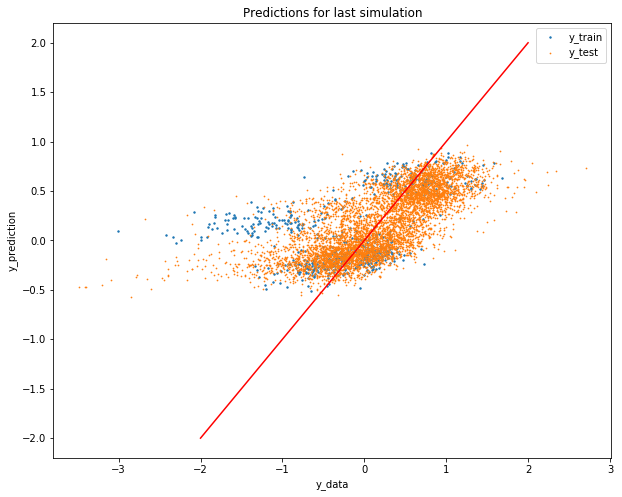

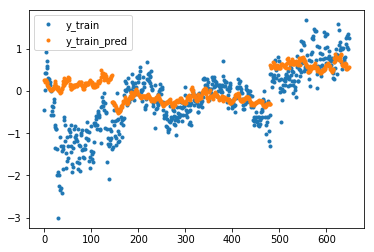

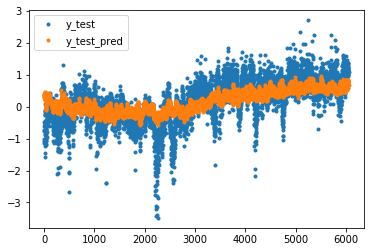

time (sec):   0.5921


In [14]:
model = Ridge(solver='lsqr', alpha = 930.)
poly  = PolynomialFeatures(degree = 3)
X_pol = poly.fit_transform(X)

t_start = time.time()

train_error = []
test_error  = []
cum_pred    = []  # cumulative emission from train and test prediction
cum_mixd    = []  # cumulative emission from train measurement and test prediction

print("train_groups     season_of_train_groups    train_err   test_err   EF_pred")
print(" ")

for train, test in cv.split( X, y, groups=groups ):
    
    X_train, y_train = X[train], y[train]
    X_test, y_test   = X[test], y[test]
    groups_test      = groups[test]
    groups_train     = groups[train]

    X_train = scaler.fit_transform(X_train) # calc mean and std for Train set and scale
    X_test  = scaler.transform(X_test)      # scale Test with mean and std from train set
    
    model.fit(X_train, y_train, groups_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_err    = mae(y_train, y_train_pred)
    test_err     = mae(y_test, y_test_pred)
    
    train_error.append( train_err )
    test_error.append( test_err )
    
    ef_pred_pred = np.sum(np.exp(y_train_pred))/1000 + np.sum(np.exp(y_test_pred))/1000
    ef_meas_pred = np.sum(np.exp(y_train))/1000      + np.sum(np.exp(y_test_pred))/1000
    
    cum_pred.append( ef_pred_pred )
    cum_mixd.append( ef_meas_pred )
    
    group_list = list(valfilter(lambda count: count > 1, frequencies(groups[train])).keys())

    season_list = [gr_season[group_list[0]],gr_season[group_list[1]],gr_season[group_list[2]],gr_season[group_list[3]]]
    
    print(group_list, season_list, round(train_err,4), round(test_err, 4), round(ef_meas_pred, 4), sep = "     " )

print(" ")
print("EF (y_train_pred + y_test_pred), mean, std:  ", round(np.mean(cum_pred),3), round(np.std(cum_pred),3), sep = "  " )
print("EF (y_train      + y_test_pred), mean, std:  ", round(np.mean(cum_mixd),3), round(np.std(cum_mixd),3), sep = "  " )
print(" ")
print("Experimental reference value, sum, error:    ", sum_exp, round(sum_cor-sum_exp, 3), sep = "  " )


plt.figure(figsize=(10, 8))
plt.scatter(y_train, y_train_pred, s=2.0, label='y_train')
plt.scatter(y_test, y_test_pred, s=0.5, label='y_test')
plt.plot([-2, 2.], [-2, 2.], 'r')
plt.xlabel("y_data")
plt.ylabel("y_prediction")
plt.title("Predictions for last simulation")
plt.legend()
plt.show()

plt.figure()
plt.plot(y_train, '.', label='y_train')
plt.plot(y_train_pred, '.', label='y_train_pred')
plt.legend()
plt.show()

plt.figure()
plt.plot(y_test, '.', label='y_test')
plt.plot(y_test_pred, '.', label='y_test_pred')
plt.legend()
plt.show()

t = round((time.time() - t_start), 4)
print("time (sec):  ", t)


## Random Forest

train_groups     season_of_train_groups    train_err   test_err   EF_pred
 
[0, 3, 9, 38]     [2, 2, 3, 1]     0.3008     0.3779     10.0677
[10, 23, 31, 32]     [3, 2, 1, 1]     0.0635     0.3491     9.6926
[3, 4, 12, 36]     [2, 2, 3, 1]     0.074     0.3452     9.288
[2, 23, 34, 35]     [2, 2, 1, 1]     0.08     0.4666     8.7581
[8, 13, 19, 31]     [2, 3, 2, 1]     0.0668     0.379     8.8287
[1, 11, 15, 29]     [2, 3, 3, 1]     0.0581     0.3883     7.83
[3, 23, 26, 38]     [2, 2, 2, 1]     0.0746     0.4295     8.998
[3, 29, 30, 35]     [2, 1, 1, 1]     0.072     0.5513     7.5875
[0, 16, 17, 22]     [2, 3, 3, 2]     0.2401     0.7089     5.4486
[0, 8, 15, 37]     [2, 2, 3, 1]     0.2935     0.3969     7.855
 
EF (y_train_pred + y_test_pred), mean, std:    8.434  1.26
EF (y_train      + y_test_pred), mean, std:    8.435  1.261
 
Experimental reference value, sum, error:    9.439  0.0


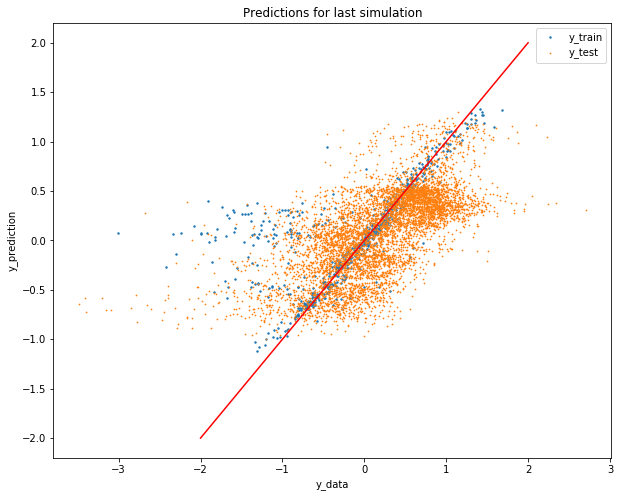

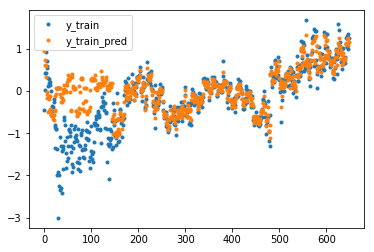

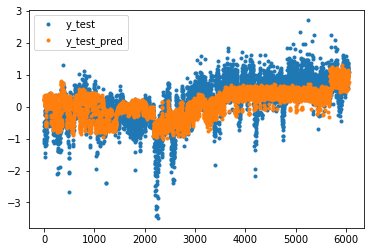

time (sec):   5.1826


In [15]:
model = RandomForestRegressor(n_estimators = 100, n_jobs = -1)   # mind. 100

t_start = time.time()

train_error = []
test_error  = []
cum_pred    = []  # cumulative emission from train and test prediction
cum_mixd    = []  # cumulative emission from train measurement and test prediction

print("train_groups     season_of_train_groups    train_err   test_err   EF_pred")
print(" ")

for train, test in cv.split( X, y, groups=groups ):
    
    X_train, y_train = X[train], y[train]
    X_test, y_test   = X[test], y[test]
    groups_test      = groups[test]
    groups_train     = groups[train]

    X_train = scaler.fit_transform(X_train) # calc mean and std for Train set and scale
    X_test  = scaler.transform(X_test)      # scale Test with mean and std from train set
    
    model.fit(X_train, y_train, groups_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_err    = mae(y_train, y_train_pred)
    test_err     = mae(y_test, y_test_pred)
    
    train_error.append( train_err )
    test_error.append( test_err )
    
    ef_pred_pred = np.sum(np.exp(y_train_pred))/1000 + np.sum(np.exp(y_test_pred))/1000
    ef_meas_pred = np.sum(np.exp(y_train))/1000      + np.sum(np.exp(y_test_pred))/1000
    
    cum_pred.append( ef_pred_pred )
    cum_mixd.append( ef_meas_pred )
    
    group_list = list(valfilter(lambda count: count > 1, frequencies(groups[train])).keys())

    season_list = [gr_season[group_list[0]],gr_season[group_list[1]],gr_season[group_list[2]],gr_season[group_list[3]]]
    
    print(group_list, season_list, round(train_err,4), round(test_err, 4), round(ef_meas_pred, 4), sep = "     " )

print(" ")
print("EF (y_train_pred + y_test_pred), mean, std:  ", round(np.mean(cum_pred),3), round(np.std(cum_pred),3), sep = "  " )
print("EF (y_train      + y_test_pred), mean, std:  ", round(np.mean(cum_mixd),3), round(np.std(cum_mixd),3), sep = "  " )
print(" ")
print("Experimental reference value, sum, error:  ", sum_exp, round(sum_cor-sum_exp, 3), sep = "  " )


plt.figure(figsize=(10, 8))
plt.scatter(y_train, y_train_pred, s=2.0, label='y_train')
plt.scatter(y_test, y_test_pred, s=0.5, label='y_test')
plt.plot([-2, 2.], [-2, 2.], 'r')
plt.xlabel("y_data")
plt.ylabel("y_prediction")
plt.title("Predictions for last simulation")
plt.legend()
plt.show()

plt.figure()
plt.plot(y_train, '.', label='y_train')
plt.plot(y_train_pred, '.', label='y_train_pred')
plt.legend()
plt.show()

plt.figure()
plt.plot(y_test, '.', label='y_test')
plt.plot(y_test_pred, '.', label='y_test_pred')
plt.legend()
plt.show()

t = round((time.time() - t_start), 4)
print("time (sec):  ", t)


## Support Vector Machine (SVM)

train_groups     season_of_train_groups    train_err   test_err   EF_pred
 
[0, 3, 9, 38]     [2, 2, 3, 1]     0.3076     0.4922     9.4852
[10, 23, 31, 32]     [3, 2, 1, 1]     0.094     0.5522     10.7828
[3, 4, 12, 36]     [2, 2, 3, 1]     0.1036     0.4875     8.8513
[2, 23, 34, 35]     [2, 2, 1, 1]     0.1161     0.5937     15.111
[8, 13, 19, 31]     [2, 3, 2, 1]     0.0873     0.5741     8.2611
[1, 11, 15, 29]     [2, 3, 3, 1]     0.0986     0.4876     9.3601
[3, 23, 26, 38]     [2, 2, 2, 1]     0.1018     0.5301     11.8838
[3, 29, 30, 35]     [2, 1, 1, 1]     0.0977     0.5325     10.9724
[0, 16, 17, 22]     [2, 3, 3, 2]     0.2691     0.876     4.8295
[0, 8, 15, 37]     [2, 2, 3, 1]     0.3434     0.564     7.3869
 
EF (y_train_pred + y_test_pred), mean, std:    9.705  2.601
EF (y_train      + y_test_pred), mean, std:    9.692  2.624
 
Experimental reference value, sum, error:    9.439  0.0


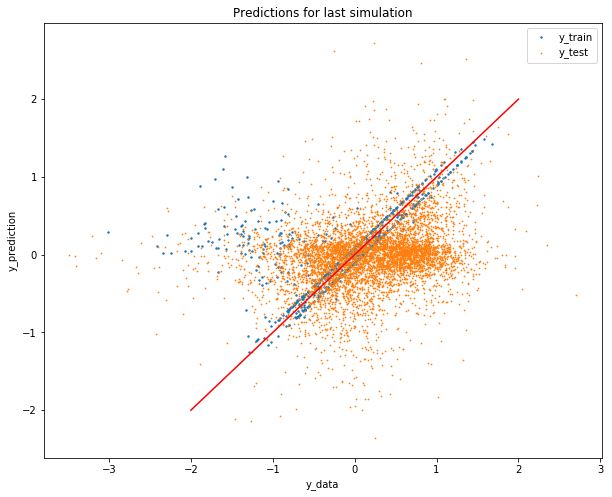

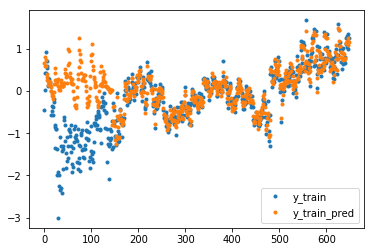

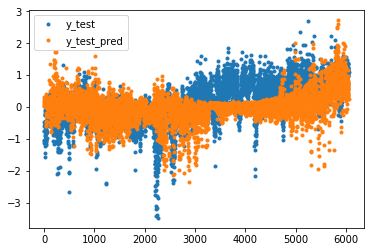

time (sec):   2.2859


In [16]:
#model = SVR(kernel = 'rbf', C=0.38, gamma=0.034, epsilon=0.1)
model = SVR(kernel = 'rbf', C=2.87, gamma=0.397, epsilon=0.1)

t_start = time.time()

train_error = []
test_error  = []
cum_pred    = []  # cumulative emission from train and test prediction
cum_mixd    = []  # cumulative emission from train measurement and test prediction

print("train_groups     season_of_train_groups    train_err   test_err   EF_pred")
print(" ")

for train, test in cv.split( X, y, groups=groups ):
    
    X_train, y_train = X[train], y[train]
    X_test, y_test   = X[test], y[test]
    groups_test      = groups[test]
    groups_train     = groups[train]

    X_train = scaler.fit_transform(X_train) # calc mean and std for Train set and scale
    X_test  = scaler.transform(X_test)      # scale Test with mean and std from train set
    
    model.fit(X_train, y_train, groups_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    train_err    = mae(y_train, y_train_pred)
    test_err     = mae(y_test, y_test_pred)
    
    train_error.append( train_err )
    test_error.append( test_err )
    
    ef_pred_pred = np.sum(np.exp(y_train_pred))/1000 + np.sum(np.exp(y_test_pred))/1000
    ef_meas_pred = np.sum(np.exp(y_train))/1000      + np.sum(np.exp(y_test_pred))/1000
    
    cum_pred.append( ef_pred_pred )
    cum_mixd.append( ef_meas_pred )
    
    group_list = list(valfilter(lambda count: count > 1, frequencies(groups[train])).keys())

    season_list = [gr_season[group_list[0]],gr_season[group_list[1]],gr_season[group_list[2]],gr_season[group_list[3]]]
    
    print(group_list, season_list, round(train_err,4), round(test_err, 4), round(ef_meas_pred, 4), sep = "     " )

print(" ")
print("EF (y_train_pred + y_test_pred), mean, std:  ", round(np.mean(cum_pred),3), round(np.std(cum_pred),3), sep = "  " )
print("EF (y_train      + y_test_pred), mean, std:  ", round(np.mean(cum_mixd),3), round(np.std(cum_mixd),3), sep = "  " )
print(" ")
print("Experimental reference value, sum, error:  ", sum_exp, round(sum_cor-sum_exp, 3), sep = "  " )


plt.figure(figsize=(10, 8))
plt.scatter(y_train, y_train_pred, s=2.0, label='y_train')
plt.scatter(y_test, y_test_pred, s=0.5, label='y_test')
plt.plot([-2, 2.], [-2, 2.], 'r')
plt.xlabel("y_data")
plt.ylabel("y_prediction")
plt.title("Predictions for last simulation")
plt.legend()
plt.show()

plt.figure()
plt.plot(y_train, '.', label='y_train')
plt.plot(y_train_pred, '.', label='y_train_pred')
plt.legend()
plt.show()

plt.figure()
plt.plot(y_test, '.', label='y_test')
plt.plot(y_test_pred, '.', label='y_test_pred')
plt.legend()
plt.show()

t = round((time.time() - t_start), 4)
print("time (sec):  ", t)
